In [1]:
using LinearAlgebra
using Plots
using DifferentialEquations

In [2]:
# Parámetros físicos reales del robot
struct RobotParams
    m1::Float64  # masa del link 1 [kg]
    m2::Float64  # masa del link 2 [kg] 
    l1::Float64  # longitud del link 1 [m]
    l2::Float64  # longitud del link 2 [m]
    g::Float64   # gravedad [m/s²]
end

# Parámetros reales
params_real = RobotParams(4.0, 2.0, 0.4, 0.2, 9.81)

# Parámetros nominales (20% de incertidumbre)
params_nominal = RobotParams(3.2, 1.6, 0.32, 0.16, 9.81)

RobotParams(3.2, 1.6, 0.32, 0.16, 9.81)

In [3]:
# Función para calcular parámetros auxiliares
function calc_auxiliary_params(p::RobotParams)
    α1 = p.l2^2 * p.m2 + p.l1^2 * (p.m1 + p.m2)
    α2 = p.l1 * p.l2 * p.m2
    α3 = p.l2^2 * p.m2
    return α1, α2, α3
end

calc_auxiliary_params (generic function with 1 method)

In [4]:
# Matriz de inercia M(q)
function inertia_matrix(q, p::RobotParams)
    α1, α2, α3 = calc_auxiliary_params(p)
    c2 = cos(q[2])
    
    M = [α1 + 2*α2*c2    α3 + α2*c2;
         α3 + α2*c2      α3]
    return M
end

inertia_matrix (generic function with 1 method)

In [5]:
# Matriz de Coriolis C(q,q̇)
function coriolis_matrix(q, qd, p::RobotParams)
    α1, α2, α3 = calc_auxiliary_params(p)
    s2 = sin(q[2])
    
    C = [-α2*s2*qd[2]           -α2*s2*(qd[1] + qd[2]);
          α2*s2*qd[1]           0]
    return C
end

coriolis_matrix (generic function with 1 method)

In [6]:
# Vector de gravedad g(q)
function gravity_vector(q, p::RobotParams)
    α1, α2, α3 = calc_auxiliary_params(p)
    c1 = cos(q[1])
    c12 = cos(q[1] + q[2])
    
    g1 = (1/p.l2) * p.g * α3 * c12 + p.g * p.l1 * (p.m1 + p.m2 - α3) * c1
    g2 = (1/p.l2) * p.g * α3 * c12
    
    return [g1, g2]
end

gravity_vector (generic function with 1 method)

In [7]:
# Función de saturación
function sat(x, δ)
    return sign(x) * min(abs(x), δ)
end

# Función de saturación vectorial
function sat_vec(x, δ)
    return [sat(xi, δi) for (xi, δi) in zip(x, δ)]
end

sat_vec (generic function with 1 method)

In [8]:
# Parámetros de control
struct ControlParams
    r1::Float64
    r2::Float64
    mc::Float64
    K::Float64
    D::Float64
    δ1::Vector{Float64}
    δ2::Vector{Float64}
    δ3::Vector{Float64}
    δ4::Vector{Float64}
end

In [9]:
# Función s(q̇,q̃) para CS2 y CS3
function s_function(qd, q_tilde, params::ControlParams)
    return params.D^(params.r1/params.r2) * abs.(qd).^(params.r1/params.r2) .* sign.(qd) + q_tilde
end

s_function (generic function with 1 method)

In [10]:
# Controlador CS1
function controller_CS1(q, qd, qd_desired, q_desired, params_ctrl::ControlParams, params_robot::RobotParams)
    q_tilde = q - q_desired
    g_q = gravity_vector(q, params_robot)
    
    term1 = params_ctrl.K * sat_vec(abs.(q_tilde).^(params_ctrl.mc/params_ctrl.r1) .* sign.(q_tilde), params_ctrl.δ1)
    term2 = params_ctrl.D * sat_vec(abs.(qd).^(params_ctrl.mc/params_ctrl.r2) .* sign.(qd), params_ctrl.δ2)
    
    τ = g_q - term1 - term2
    return τ
end

controller_CS1 (generic function with 1 method)

In [11]:
# Controlador CS2  
function controller_CS2(q, qd, qd_desired, q_desired, params_ctrl::ControlParams, params_robot::RobotParams)
    q_tilde = q - q_desired
    s_val = s_function(qd, q_tilde, params_ctrl)
    g_q = gravity_vector(q, params_robot)
    
    term1 = params_ctrl.K * sat_vec(abs.(s_val).^(params_ctrl.mc/params_ctrl.r1) .* sign.(s_val), params_ctrl.δ1)
    term2 = params_ctrl.D * sat_vec(abs.(qd).^(params_ctrl.mc/params_ctrl.r2) .* sign.(qd), params_ctrl.δ2)
    
    τ = g_q - term1 - term2
    return τ
end

controller_CS2 (generic function with 1 method)

In [12]:
# Controlador CS3
function controller_CS3(q, qd, qd_desired, q_desired, params_ctrl::ControlParams, params_robot::RobotParams)
    q_tilde = q - q_desired
    g_q = gravity_vector(q, params_robot)
    
    qd_term = abs.(qd).^(params_ctrl.r1/params_ctrl.r2) .* sign.(qd)
    q_tilde_term = abs.(q_tilde).^(params_ctrl.mc/params_ctrl.r1) .* sign.(q_tilde)
    
    combined_term = params_ctrl.K/params_ctrl.D^(params_ctrl.r1/params_ctrl.r2) * sat_vec(qd_term, params_ctrl.δ3) + sat_vec(q_tilde_term, params_ctrl.δ4)
    term1 = combined_term
    term2 = params_ctrl.D * sat_vec(abs.(qd).^(params_ctrl.mc/params_ctrl.r2) .* sign.(qd), params_ctrl.δ2)
    
    τ = g_q - term1 - term2
    return τ
end

controller_CS3 (generic function with 1 method)

In [13]:
# Controlador CTC (para comparación)
function controller_CTC(q, qd, qd_desired, q_desired, params_ctrl::ControlParams, params_robot::RobotParams, params_nominal::RobotParams)
    q_tilde = q - q_desired
    
    # Usar parámetros nominales
    M0 = inertia_matrix(q, params_nominal)
    C0 = coriolis_matrix(q, qd, params_nominal)
    g0 = gravity_vector(q, params_nominal)
    
    # Parámetros CTC
    k1 = 1.0
    k2 = params_ctrl.K
    λ = params_ctrl.D^(params_ctrl.r1/params_ctrl.r2)
    
    # Sliding variable
    σ = qd + λ * q_tilde
    
    # Control law
    v = -k1 * σ - k2 * sign.(σ)
    τ = C0 * qd + g0 + M0 * v
    
    return τ
end

controller_CTC (generic function with 1 method)

In [14]:
# Función para definir las configuraciones de ganancia
function get_control_params(tuning_case::String)
    r1, r2, mc = 3/2, 1.0, 1.0
    
    if tuning_case == "T1"
        K, D = 3.0, 3.0
        δ1, δ2 = [0.4, 0.4], [1.2, 1.2]
    elseif tuning_case == "T2"
        K, D = 3.0, 3.0
        δ1, δ2 = [1.2, 1.2], [0.4, 0.4]
    elseif tuning_case == "T3"
        K, D = 4.0, 3.0
        δ1, δ2 = [1.2, 1.2], [0.4, 0.4]
    elseif tuning_case == "T4"
        K, D = 4.0, 3.0
        δ1, δ2 = [0.4, 0.4], [1.2, 1.2]
    else
        error("Tuning case not recognized")
    end
    
    # Para CS3
    δ4 = (D .* δ1).^(r1/r2)
    δ3 = δ1
    
    return ControlParams(r1, r2, mc, K, D, δ1, δ2, δ3, δ4)
end

get_control_params (generic function with 1 method)

In [15]:
# Sistema dinámico del robot
function robot_dynamics!(du, u, p, t)
    q = u[1:2]
    qd = u[3:4]
    
    controller_func, params_ctrl, params_real, params_nominal, q_desired, qd_desired = p
    
    # Calcular el torque de control
    τ = controller_func(q, qd, qd_desired, q_desired, params_ctrl, params_real, params_nominal)
    
    # Dinámicas del robot
    M = inertia_matrix(q, params_real)
    C = coriolis_matrix(q, qd, params_real)
    g = gravity_vector(q, params_real)
    
    # q̈ = M⁻¹(τ - Cq̇ - g)
    qdd = M \ (τ - C * qd - g)
    
    du[1:2] = qd
    du[3:4] = qdd
end

robot_dynamics! (generic function with 1 method)

In [16]:
# Función de simulación
function simulate_controller(controller_func, tuning_case::String, tspan=(0.0, 15.0))
    # Condiciones iniciales
    q0 = [0.0, 0.0]
    qd0 = [0.0, 0.0]
    u0 = [q0; qd0]
    
    # Posición deseada
    q_desired = [-2.0, 3.0]
    qd_desired = [0.0, 0.0]
    
    # Parámetros de control
    params_ctrl = get_control_params(tuning_case)
    
    # Parámetros del problema
    if controller_func == controller_CTC
        p = (controller_func, params_ctrl, params_real, params_nominal, q_desired, qd_desired)
    else
        p = ((q, qd, qd_des, q_des, pc, pr, pn) -> controller_func(q, qd, qd_des, q_des, pc, pr), 
             params_ctrl, params_real, params_nominal, q_desired, qd_desired)
    end
    
    # Resolver EDO
    prob = ODEProblem(robot_dynamics!, u0, tspan, p)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat=0.001)
    
    return sol
end

simulate_controller (generic function with 2 methods)

In [17]:
# Función para graficar resultados
function plot_results(solutions, labels, tuning_case)
    t = solutions[1].t
    
    # Crear subplots
    p1 = plot(title="Position q₁ - $tuning_case", xlabel="Time [s]", ylabel="q₁ [rad]")
    p2 = plot(title="Error q̃₁ - $tuning_case", xlabel="Time [s]", ylabel="q̃₁ [rad]")
    p3 = plot(title="Position q₂ - $tuning_case", xlabel="Time [s]", ylabel="q₂ [rad]")
    p4 = plot(title="Error q̃₂ - $tuning_case", xlabel="Time [s]", ylabel="q̃₂ [rad]")
    
    q_desired = [-2.0, 3.0]
    
    for (i, (sol, label)) in enumerate(zip(solutions, labels))
        q1 = [u[1] for u in sol.u]
        q2 = [u[2] for u in sol.u]
        q1_tilde = q1 .- q_desired[1]
        q2_tilde = q2 .- q_desired[2]
        
        plot!(p1, t, q1, label=label, linewidth=2)
        plot!(p2, t, q1_tilde, label=label, linewidth=2)
        plot!(p3, t, q2, label=label, linewidth=2)
        plot!(p4, t, q2_tilde, label=label, linewidth=2)
    end
    
    # Líneas de referencia
    hline!(p1, [q_desired[1]], line=:dash, color=:black, label="Desired", linewidth=1)
    hline!(p2, [0], line=:dash, color=:black, label="Zero Error", linewidth=1)
    hline!(p3, [q_desired[2]], line=:dash, color=:black, label="Desired", linewidth=1)
    hline!(p4, [0], line=:dash, color=:black, label="Zero Error", linewidth=1)
    
    return plot(p1, p2, p3, p4, layout=(2,2), size=(800,600))
end

plot_results (generic function with 1 method)

In [18]:
# Función principal para ejecutar simulaciones
function run_simulation(tuning_case="T1")
    println("Ejecutando simulación con configuración $tuning_case...")
    
    # Simular cada controlador
    sol_CS1 = simulate_controller(controller_CS1, tuning_case)
    sol_CS2 = simulate_controller(controller_CS2, tuning_case)  
    sol_CS3 = simulate_controller(controller_CS3, tuning_case)
    sol_CTC = simulate_controller(controller_CTC, tuning_case)
    
    solutions = [sol_CS1, sol_CS2, sol_CS3, sol_CTC]
    labels = ["CS1", "CS2", "CS3", "CTC"]
    
    # Graficar resultados
    plt = plot_results(solutions, labels, tuning_case)
    display(plt)
    
    println("Simulación completada!")
    return solutions, plt
end

run_simulation (generic function with 2 methods)

Ejecutando simulación con configuración T1...


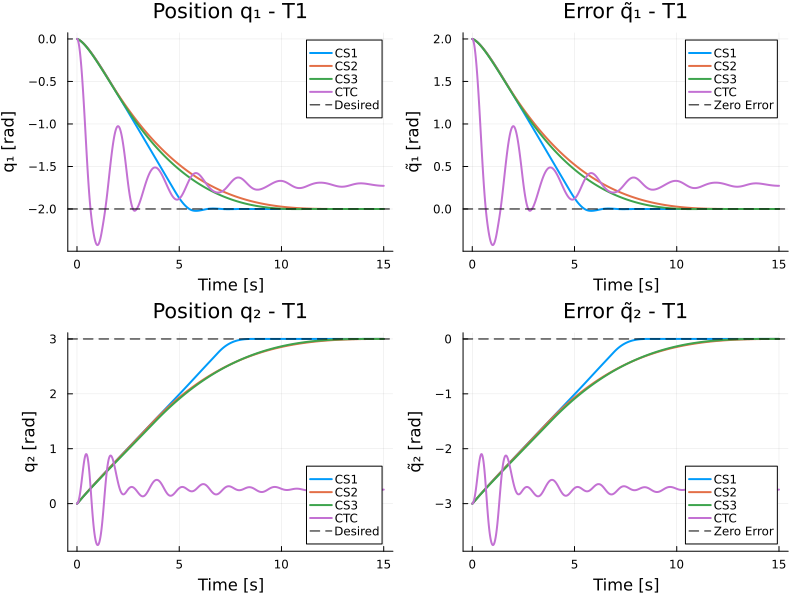

Simulación completada!


LoadError: cannot assign a value to imported variable Plots.plot from module Main

In [20]:
# Ejemplo de uso
solutions, plot = run_simulation("T1")